# Baixando as bibliotecas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mlforecast dill

# Importando as bibliotecas

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dill as pickle

from utilsforecast.plotting import plot_series


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression
)

import warnings
warnings.filterwarnings('ignore')

# Carregando os dados

In [4]:
bucket_uri = "/content/drive/MyDrive/M5_full.parquet"

In [5]:
dados = pd.read_parquet(bucket_uri)

In [6]:
dados['date'] = pd.to_datetime(dados['date'])

### Foi necessário remover o mês por não ser um mês completo e estava atrapalhando nas previsões

In [7]:
ano = 2016
mes = 5

dados = dados[~((dados['date'].dt.year == ano) & (dados['date'].dt.month == mes))]

In [8]:
dados.set_index('date', inplace=True)

# Criando série temporal de todos os produtos

In [9]:
produtos = dados.groupby(['id']).resample('MS')['value'].sum()

## Série temporal do top 100 produtos

In [10]:
top_100_produtos = produtos.groupby('id').sum().nlargest(100).index

In [11]:
produtos = produtos[produtos.index.get_level_values('id').isin(top_100_produtos)]

# Divisão entre treino e teste com previsão de 6 meses

In [12]:
teste_size = 6
teste = produtos.groupby(['id']).tail(teste_size)
train = produtos.drop(teste.index)

# Transformando o DataFrame para o padrão Nixtla

In [13]:
df_train = train.reset_index()
df_test = teste.reset_index()

In [14]:
df_train = df_train.rename(columns={'date': 'ds',
                                    'value': 'y',
                                    'id': 'unique_id'})

df_test = df_test.rename(columns={'date': 'ds',
                                  'value': 'y',
                                  'id': 'unique_id'})

## Procurando o melhor modelo para a previsão

In [15]:
models={
        'lgb': AutoLightGBM(),
         'rf' : AutoRandomForest(),
         'xgb' : AutoXGBoost(),
         'linear' : AutoLinearRegression()
        }

In [16]:
auto_mlf = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=12,
)

In [17]:
auto_mlf.fit(
    df_train,
    n_windows=6,
    h=6,
    num_samples=8,
)

[I 2024-07-10 23:25:44,295] A new study created in memory with name: no-name-f73f3493-eba2-47c2-8d23-a5a38f588c32
[I 2024-07-10 23:25:45,121] Trial 0 finished with value: 0.20954886692215344 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 0, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is trial 0 with value: 0.20954886692215344.
[I 2024-07-10 23:25:45,891] Trial 1 finished with value: 0.22518576681613922 and parameters: {'n_estimators': 454, 'lambda_l1': 0.00014233583723829364, 'lambda_l2': 0.10586748269028218, 'num_leaves': 4, 'feature_fraction': 0.819960510663762, 'bagging_fraction': 0.5716766437045232, 'objective': 'l1', 'target_transforms_idx': 2, 'lags_idx': 1, 'lag_transforms_idx': 1, 'use_date_features': 0}. Best is trial 0 with value: 0.2095488669221534

AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'rf': AutoModel(model=RandomForestRegressor), 'xgb': AutoModel(model=XGBRegressor), 'linear': AutoModel(model=LinearRegression)})

> Para poder ver os resultados dos modelos:

In [18]:
# for model_name, result in auto_mlf.results_.items():
#     best_params = result.best_trial.user_attrs['config']
#     print(f"Best parameters for {model_name}:")
#     print(best_params)
#     print("\n")

In [19]:
preds = auto_mlf.predict(6)

In [20]:
for i in list(models.keys()):
  preds[i] = preds[i].astype(int)

## Analisando o resultado dos modelos por gráficos

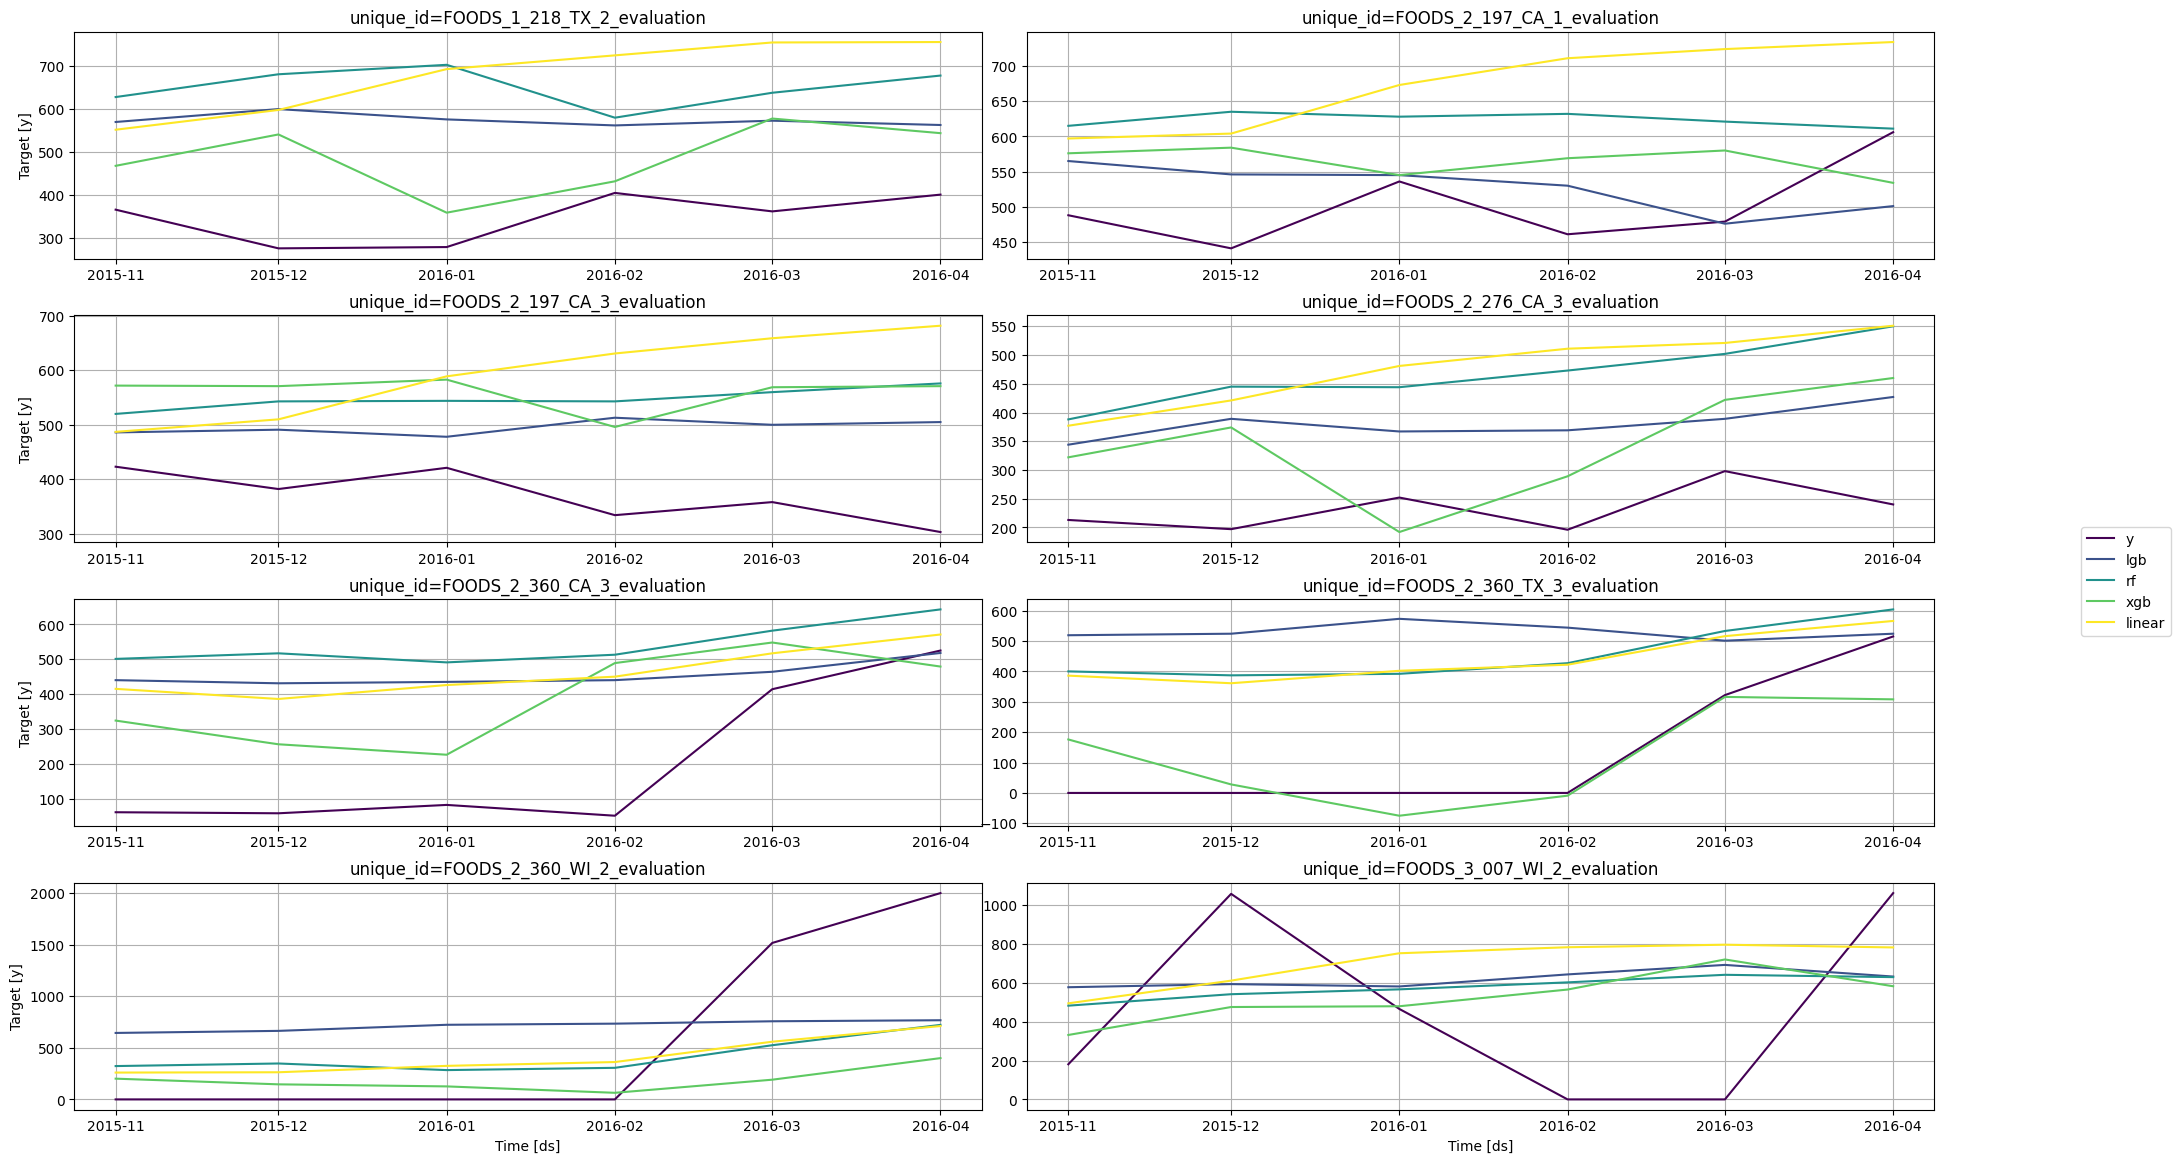

In [21]:
plot_series(df_test, preds, plot_random=False)

## Validando as métricas

In [22]:
previsao_full = df_test.merge(preds, how='right', on=['unique_id', 'ds'])

In [23]:
for i in list(models.keys()):
  print(f'------------------{i}-----------------')
  MAE = mean_absolute_error(previsao_full['y'], previsao_full[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(previsao_full['y'], previsao_full[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(previsao_full[i], df_test['y']))
  print(f'Root mean squared error: {RMSE}')


  R2 = r2_score(df_test['y'], previsao_full[i])
  print(f'R2: {R2}')
  print('\n')

------------------lgb-----------------
Mean Absolute Error: 225.085
Mean absolute percentage error: 8.434491502127043e+16
Root mean squared error: 341.2507753348945
R2: 0.6553588717554308


------------------rf-----------------
Mean Absolute Error: 235.52333333333334
Mean absolute percentage error: 7.302586795781259e+16
Root mean squared error: 360.07668164804375
R2: 0.6162840914639871


------------------xgb-----------------
Mean Absolute Error: 240.88166666666666
Mean absolute percentage error: 4.613937818241073e+16
Root mean squared error: 362.22640939979334
R2: 0.6116886975347892


------------------linear-----------------
Mean Absolute Error: 230.195
Mean absolute percentage error: 6.4979436623577304e+16
Root mean squared error: 337.01413175117744
R2: 0.6638632210025082




## Analisando o desempenho do melhor modelo

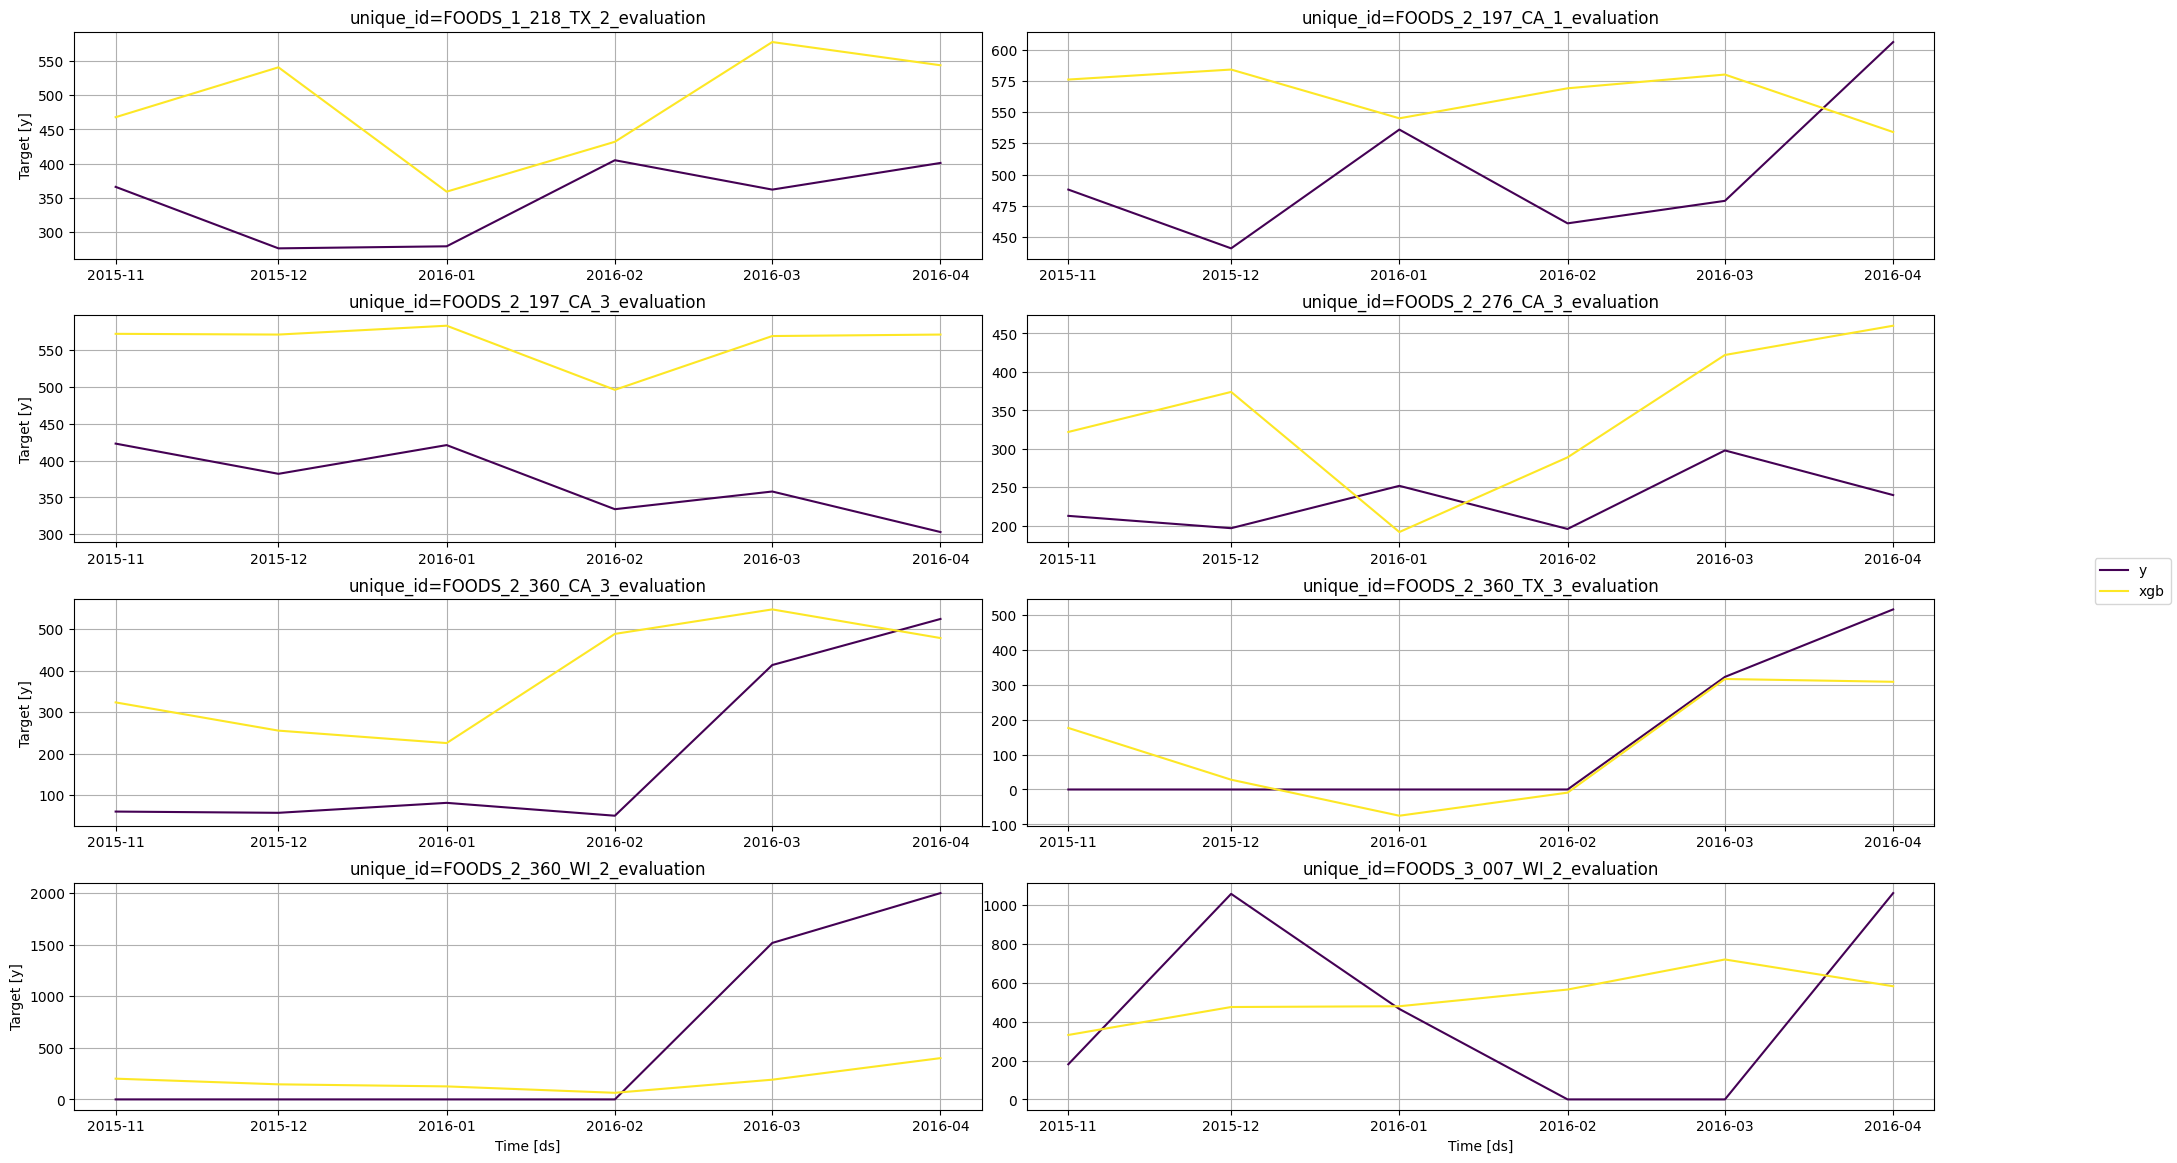

In [24]:
plot_series(df_test, preds[['unique_id', 'ds', 'xgb']], plot_random=False)

In [25]:
tabela_validacao = previsao_full[['unique_id', 'ds', 'y', 'xgb']]

## Previsão dos próximos 6 meses

In [26]:
models={
         'xgb' : AutoXGBoost()
        }

In [27]:
dados_full = pd.concat([df_train, df_test])

In [28]:
auto_mlf_full = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=12,
)

In [29]:
auto_mlf_full.fit(
    df_train,
    n_windows=6,
    h=6,
    num_samples=8,
)

[I 2024-07-10 23:26:52,258] A new study created in memory with name: no-name-0aaf6e37-98b7-4e48-901d-5f02fb84a37a
[I 2024-07-10 23:26:54,408] Trial 0 finished with value: 0.39904308319091797 and parameters: {'n_estimators': 558, 'max_depth': 8, 'learning_rate': 0.024376795198947098, 'subsample': 0.5903948646972071, 'bagging_freq': 0.4812893194050143, 'colsample_bytree': 0.6813047017599905, 'min_data_in_leaf': 44.321133915006556, 'reg_lambda': 0.13620216352659412, 'reg_alpha': 0.5120378720005675, 'min_child_weight': 5, 'target_transforms_idx': 3, 'lags_idx': 2, 'lag_transforms_idx': 2, 'use_date_features': 0}. Best is trial 0 with value: 0.39904308319091797.
[I 2024-07-10 23:26:55,066] Trial 1 finished with value: 0.22050489485263824 and parameters: {'n_estimators': 785, 'max_depth': 2, 'learning_rate': 0.02968092728356274, 'subsample': 0.22901795866814179, 'bagging_freq': 0.9502020253446255, 'colsample_bytree': 0.5696634895750645, 'min_data_in_leaf': 42.051532059061834, 'reg_lambda': 1

AutoMLForecast(models={'xgb': AutoModel(model=XGBRegressor)})

In [30]:
preds = auto_mlf_full.predict(6)

In [31]:
for i in list(models.keys()):
  preds[i] = preds[i].astype(int)

# Exportando os arquivos

# Exportando o pickle

In [32]:
# with open('ModelosPKL/produtos.pkl', 'wb') as f:
#      pickle.dump(auto_mlf_full, f)

# Previsão futuro

In [33]:
# preds.to_csv('previsao_produtos.csv', index=False)

# Validação

In [34]:
# tabela_validacao.to_csv('validacao_produtos.csv', index=False)